In [ ]:
!pip install --upgrade networkx

In [1]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
from matplotlib import animation as animation
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import networkx as nx

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

def css_styling():
    styles = open('../../notebook_styles.css', 'r').read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: '../../notebook_styles.css'

## Centrality and network dynamics

Today, we're going to talk about two topics. First, we're going to talk about *centrality*. Conceptually, we think of a node as being central when it is in the middle of the network in some way. There are many different ways of defining this concept precisely; we'll look at one example today.

Next, we're going to start to explore *dynamics* on networks. By dynamics, we mean processes that take place on the network. These processes can include important phenomena like the spread of information, influence, or a disease from one node to another.

We look at these two topics together because we expect that central nodes will play an important role in dynamical processes that take place on networks. 

### Centrality

So far, we have thought mostly about network structure and how it might result from various social processes like homophily or triadic closure. Today, we're going to change our focus to how stuff--such as information, resources, or diseases--can spread across networks.

First, we're going to investigate a network metric called *betweenness centrality* which gets at the concept of how important a node is in how things spread across networks.

The betweenness centrality of a node $v$ is defined as the fraction of all shortest paths between all pairs of nodes in the network that pass through $v$.

Mathematically, this [can be written](https://en.wikipedia.org/wiki/Betweenness_centrality)

$$bc(v) = \sum_{s, t \in V} \frac{\sigma(s, t | v)}{\sigma(s, t)},$$

where 

* $bc(v)$ is the betweenness centrality of node $v$
* $\sigma(s,t)$ is the number of shortest paths between node $s$ and node $t$ (note that there can be more than one) 
* $\sigma(s, t | v)$ is the number of the shortest paths between node $s$ and node $t$ that goes through $v$

Note that the $s$ and $t$ vary over all pairs of nodes *not counting* the node $v$ whose betweenness is being calculated.

<img src="example_network.png">

Betweenness of node 3:

1 <-> 2 contributes 1<br>
1 <-> 4 contributes 1<br>
2 <-> 4 contributes 1<br>

All other pairs contribute 0.

So, betweenness centrality for node 3 is equal to 3.


**Question** Can you think of a situation where degree and bc would differ?

<div class='response'>
[answer here]
</div>

### A simple model

A simple but very useful model for the spread of an infectious disease is called the SIR model. SIR stands for the three different states that each person in the population can be in:

* Susceptible
* Infected
* Recovered / Removed

The idea is that people can only move through the states according to the diagram below: that is, susceptible people can become infected and, once infected, people recover. Once they have recovered, they cannot be infected again, so they are immune.

We'll work with one main parameter in our exploration here:

* $\beta$ (beta) - probability of a susceptible node getting infected due to a connection to an infected neighbor

Note that beta is defined as the probability a node is infected due to contact with one *infected neighbor*. If a node has several infected neighbors, the total probability that the node will get infected increases.

<img src='sir_diagram.png'>

### Simulating an SIR epidemic

In [ ]:
# Rough outline:
#
# randomly pick a starting node to infect
#
# while any infected
#    get neighbors of infected
#    set infected to recovered
#    neighbors become infected with prob beta * # infected contacts [approximately; exact expression is 1 - (1-beta)^c]
#    record how many were infected

In [2]:
def set_status(net, ids, value):
    """
    set the value of the 'status' attribute for the nodes with the given ids
    in the given network
    """
    nx.set_node_attributes(net,  
                           dict([x for x in zip(ids, [value]*len(ids))]),
                          'status')

def get_status(net, ids):
    """
    get the value of the 'status' attributes for the nodes 
    with given ids in the given network
    """
    dat = nx.get_node_attributes(net, 'status')
    return([dat[x] for x in ids])

def count_infected_nodes(net):
    return(np.sum(np.array(list(nx.get_node_attributes(net, 'status').values())) == 'infected'))

In [3]:
def sim_epidemic(net, start_nodes=None, innoculated_nodes=None, beta=0.3, draw=False):
    
    # all nodes start susceptible
    set_status(net, net.nodes(), 'susceptible')

    # innoculated nodes start as recovered
    if innoculated_nodes is not None:
        set_status(net, innoculated_nodes, 'innoculated')
    else:
        innoculated_nodes = []

    eligible_to_start = [x for x in net.nodes() if x not in innoculated_nodes]        
        
    # if no start_nodes specified, pick one node at random as the seed
    if start_nodes is None:
        infected_nodes = np.random.choice(eligible_to_start, 1)
    else:
        infected_nodes = start_nodes

    set_status(net, infected_nodes, 'infected')

    incidence = [len(infected_nodes)]
    
    if draw:
        status_cmap = {'susceptible' : '#00FF00', 'infected' : '#FF0000', 'recovered' : '#000000', 'innoculated' : '#0000FF'}
        pos = nx.random_layout(net)
        
    while count_infected_nodes(net) > 0:

        if draw:
            next_fig, next_ax = plt.subplots() 
            plt.figure(nx.draw(net, 
                               pos=pos,
                               cmap=status_cmap, 
                               node_color=[status_cmap[net.node[node]['status']] for node in net]));

        ## get neighbors of infected nodes
        neighbors = [net.neighbors(x) for x in infected_nodes]

        # see http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
        neighbors = [item for sublist in neighbors for item in sublist]        
        neighbors_status = np.array(get_status(net, neighbors))

        ## set infected nodes to recovered
        set_status(net, infected_nodes, 'recovered')

        ## infect susceptible neighbors with probability beta x number of infected contacts
        ## (a node with more than one infected contact will have more than one draws at being infected here)
        neighbors = [x[0] for x in zip(neighbors, neighbors_status) if x[1] == 'susceptible']
        infect_draws = np.random.random_sample(len(neighbors))
        #print(infect_draws)
        to_infect = list(np.array(neighbors)[np.where(infect_draws < beta)])

        num_infected_this_round = len(set(to_infect))
        
        set_status(net, to_infect, 'infected')
        infected_nodes = to_infect

        ## record number infected this round (also called incidence at this time step)
        incidence.append(num_infected_this_round)
    
    return incidence

### SIR model: illustration

The code above takes a given network and simulates an SIR epidemic on it. It returns a list that has the *incidence* -- that is, the number of new infections -- at each time step. By adding these values up, we can tell how many people ended up being infected by the outbreak.

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


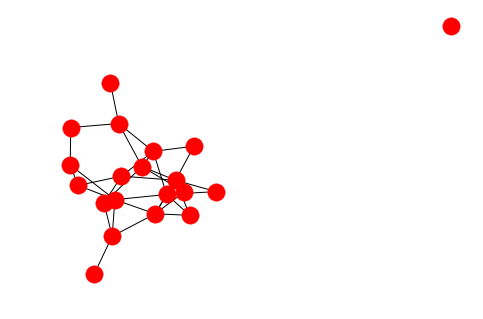

In [4]:
np.random.seed(seed=101)
er_net_example = nx.erdos_renyi_graph(n=20, p=.2)

nx.draw(er_net_example)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


[1, 2, 1, 2, 3, 3, 1, 0]

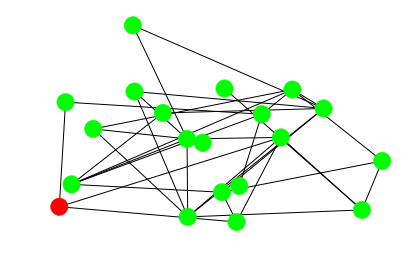

<Figure size 432x288 with 0 Axes>

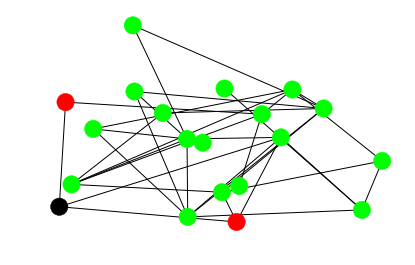

<Figure size 432x288 with 0 Axes>

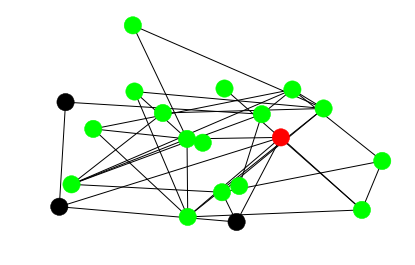

<Figure size 432x288 with 0 Axes>

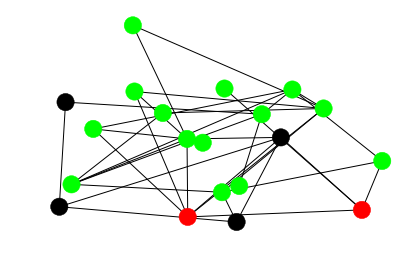

<Figure size 432x288 with 0 Axes>

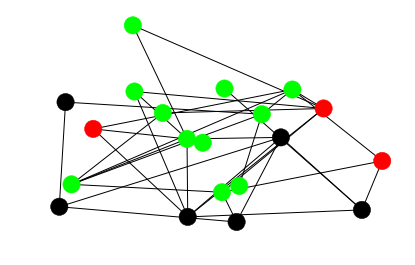

<Figure size 432x288 with 0 Axes>

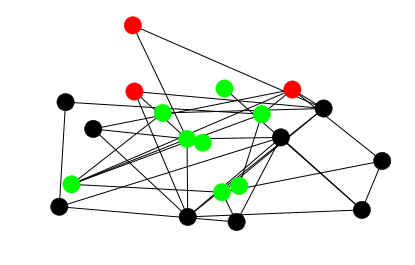

<Figure size 432x288 with 0 Axes>

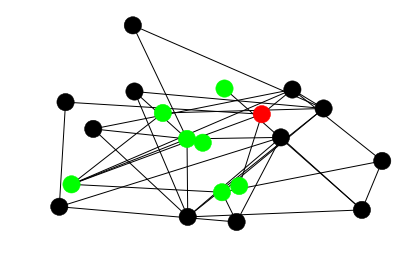

<Figure size 432x288 with 0 Axes>

In [5]:
np.random.seed(seed=100)
res = sim_epidemic(er_net_example, beta=.3, draw=True)
res

## Activity

<img src="example_network0.png">

**Question**   
**(a)** Fill in the table below with the distance and the number of shortest paths between each pair of vertices. (For example, if there are three shortest paths each of length 2, write 2 (3) in the table.)  
**(b)** Calculate the betweenness centrality for node 3 and for node 1.

In [ ]:
#        node 1  node 2  node 3  node 4  node 5
# node 1   -      ?(?)    ?(?)    ?(?)    ?(?)
# node 2   -       -      ?(?)    ?(?)    ?(?)
# node 3   -       -       -      ?(?)    ?(?)
# node 4   -       -       -       -      ?(?)
# node 5   -       -       -       -       - 

In [ ]:
#SOLUTION

#        node 1  node 2  node 3  node 4  node 5
# node 1   -      2(1)    1(1)    1(1)    2(2)
# node 2   -       -      1(1)    2(1)    2(1)
# node 3   -       -       -      1(1)    1(1)
# node 4   -       -       -       -      1(1)
# node 5   -       -       -       -       - 

<div class='solution'>
betweenness centrality for node 3: (1/1) + 0 + 0 + (1/2) + (1/1) + (1/1) + 0 = 3.5  
    
betweenness centrality for node 1: 0   
</div>

Check your calculation using the `nx.betweenness_centrality` function.  
*[NB: be sure to set the normalized argument to False]*.

In [ ]:
test_net = nx.Graph([(1,3), (1, 4), (2,3), (3,4), (3,5), (4,5)])
nx.betweenness_centrality(test_net, normalized=False)

### SIR model in Erdos-Renyi random networks

The SIR model is *stochastic*, meaning that it involves randomness: every time you simulate the course of an epidemic using an SIR model, you can get different outcomes. (We saw something similar when we looked at how to generate random networks using the ER model.)

We'll start studying the SIR model by running it repeatedly on the same network and looking at how much variation there is in the resulting epidemic.

Run the SIR model once on the network `er_net_example` and calculate how many people get infected in total.

In [ ]:
np.sum(sim_epidemic(er_net_example, beta=.7))

Write some code that runs 1000 simulated ER epidemics on the network `er_net_example` with beta of 0.3. Make a histogram that shows how much variation there is in the total number of people infected in each simulation. (Recall that we generated `er_net_example` above, using the ER random network model.)

In [ ]:
num_infected = make_array()

for _ in range(1000):
    num_infected = np.append(num_infected, np.sum(sim_epidemic(er_net_example, beta=.3)))
    
Table().with_column('num_infected', num_infected).hist()

Write a simulation that varies the beta parameter and studies how the number of people infected varies as beta increases from 0.1 to 0.8. Use the network `er_net_example` for your simulations.

In [ ]:
num_infected = make_array()
beta_val = make_array()

## vary beta across the range 0.1 to 0.8
for cur_beta in np.arange(.1, .9, .1):
    ## for each value of beta, run 1000 simulated epidemics
    for _ in range(1000):
        num_infected = np.append(num_infected, np.sum(sim_epidemic(er_net_example, beta=cur_beta)))
        beta_val = np.append(beta_val, cur_beta)
    
beta_sim_res = Table().with_columns(['beta', beta_val,
                                     'num_infected', num_infected])

beta_sim_res

Now make a scatter plot of the value of beta (x axis) to the average number of people infected across the simulations for each value of beta (y axis).

In [ ]:
# FIRST TRY
beta_sim_res.scatter('beta', 'num_infected')

In [ ]:
beta_sim_res.group('beta', np.mean).scatter('beta', 'num_infected mean')

Now let's visualize the results in a second way. Make a scatterplot that compares the value of beta (x axis) to the number of people infected in each simulation (y axis). (Use the `alpha` parameter to avoid misleading results due to overplotting.)

In [ ]:
beta_sim_res.scatter('beta', 'num_infected', alpha=.05)

What do you conclude from the two plots above? How does increasing beta affect the number of people who are infected in an SIR model on the network `er_net_example`?

<div class='solution'>
The first plot shows that the expected number of people infected increases as beta increases, though it looks like this increase is not linear but instead S-shaped: the increase in the expected value is slow, then fast, then slow again.  

The second scatter plot shows that just looking at the expected value masks some more complex behavior: although the average increases, it looks like there may be two different regimes of behavior: one where the epidemic dies out pretty quickly, and one where the epidemic continually increases in size. This suggests that the variance around the expected values shown in the first plot is probably pretty big.
</div>

### Innoculating nodes

The function `sim_epidemic` can take an optional parameter called `innoculated_nodes`, which is a list with the ids of nodes that are assumed to be impervious to the infection.

For example, the following code would run a simulation with node number 10 innoculated:

`sim_epidemic(er_net_example, innoculated_nodes=[10], beta=.3)`

We might hope that if we innoculate the right node, we can reduce the total number of people who get infected by the epidemic. The question is: what kind of nodes should be innoculated?

**Question** Suppose you picked one node in a network and innoculated it. What relationship would you expect to find between the degree of the innoculated node and the resulting number of people infected in the epidemic? For example, would you expect a positive relationship, a negative relationship or no relationship?

<div class='response'>
[answer here]
</div>

**Question** Suppose again that you picked one node in a network and innoculated it. What relationship would you expect to find between the betweenness centrality of the innoculated node and the resulting number of people infected in the epidemic? For example, would you expect a positive relationship, a negative relationship or no relationship?

<div class='response'>
[answer here]
</div>

Now we'll investigate this question empirically, using simulations.

Write a simulation that explores what impact innoculating each node in the network has on the number of people that are infected. You should loop through each node in the network `er_net_example` and simulate 1000 ER epidemics with that node innoculated. (So, only one node is ever innoculated.) Keep track of which node was innoculated and the number of people that were infected; put these simulation results into a Table called `sim_res`.

In [ ]:
sim_beta = 0.3

node_ids = make_array()
tot_num_infected = make_array()

for cur_node in er_net_example.nodes():
    for _ in range(1000):
        tot_num_infected = np.append(tot_num_infected, 
                                     np.sum(sim_epidemic(er_net_example, 
                                                         innoculated_nodes=[cur_node], 
                                                         beta=sim_beta)))
        node_ids = np.append(node_ids, cur_node)
        
sim_res = Table().with_columns(['node_id', node_ids,
                                'tot_infected', tot_num_infected])

sim_res

Your simulation results have 1000 repetitions for each innoculated node. Make an aggregated Table called `sim_res_agg` which has the node id and the average total number infected across all of the simulation runs where that node id was innoculated.   
*[Hint: Use `group` here.]*

In [ ]:
sim_res_agg = sim_res.group('node_id', np.mean)
sim_res_agg

Now make a Table that has the id of each node in the network, its degree, and its betweenness centrality.

In [ ]:
node_dat = Table().with_columns('node_id', er_net_example.nodes(),
                                'betweenness_centrality', nx.betweenness_centrality(er_net_example).values(),
                                'degree', [v for (x,v) in nx.degree(er_net_example)])

node_dat

Join the `node_dat` table onto the `sim_res_agg` table so that you have a table that has node characteristics (degree and betweenness centrality) and the average total number infected when that node is innoculated.

In [ ]:
res = sim_res_agg.join('node_id', node_dat)
res

Make a scatterplot that shows the relationship between the betweenness centrality (x axis) and the average total number infected (y axis).

In [ ]:
res.scatter('betweenness_centrality', 'tot_infected mean')

Make a scatterplot that shows the relationship between the degree (x axis) and the average total number infected (y axis).

In [ ]:
res.scatter('degree', 'tot_infected mean')

**Question** What do the plots reveal? Were the predictions you made above correct?

<div class='response'>
[answer here]
</div>

**Question** Which metric of centrality (degree or betweenness centrality) appears to be a better guide to targeting nodes for innoculation in the ER network?

<div class='response'>
[answer here]
</div>